In [1]:
%matplotlib inline
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.utils import resample

save = False

cm = 1/2.54  # centimeters in inches
sns.set_context('paper', rc={'font.size': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8,
                          'figure.titleweight': 'bold', 'axes.labelsize':10, 'axes.titlesize':12})


dir_path = os.path.abspath('')

output_path = dir_path + '/Figures/'


In [2]:
tracker = joblib.load(dir_path + '/ModelAnalysis/EvokedPotentials.pkl')

colors = sns.color_palette(sns.xkcd_palette([ "orange yellow","windows blue", "greyish", "faded green", "dusty purple","orange", "grey"]))

In [3]:
offset = 0
onset = 100
features = 256 
time_steps = np.arange(-onset, tracker['neutral']['evoked'].shape[1] - onset) 

conds = ['precision','inputGain','outputGain']

n = tracker['neutral']['evoked'].shape[0]
conds = ['precision','inputGain','outputGain']

evo_avgs = pd.DataFrame(np.zeros((len(conds) * 3 * n,4)), columns=['Mechanisms', 'Attention', 'Image', 'Potential'])

evo_avgs['Attention'] = np.repeat(np.arange(3)[np.newaxis,:],n *len(conds), axis=0).flatten()
evo_avgs['Mechanisms'] = np.repeat(np.arange(len(conds))[np.newaxis,:],n *3, axis=1).flatten()
evo_avgs['Image'] = np.repeat(np.repeat(np.arange(n)[:,np.newaxis],3).flatten()[np.newaxis,:], len(conds), axis=0).flatten()
replace_map = {'Attention': {0: 'valid', 1:'neutral', 2:'invalid'},
               'Mechanisms': {0: conds[0], 1: conds[1], 2: conds[2]}}
evo_avgs.replace(replace_map, inplace=True)


num_draws = 500
resp = tracker['neutral']['evoked'][:n, offset:]
idx = np.arange(resp.shape[0])
mean_draws_neutral = list()
for d in range(num_draws):
    # Resampling, with replacement, taking the class imbalance into account
    draw = resample(idx, random_state=d)
    mean_draws_neutral.append(np.mean(resp[draw], axis=0))


precision


inputGain


outputGain


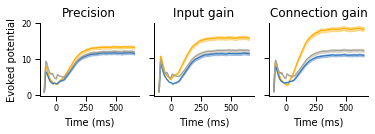

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(13.5*cm, 5*cm), sharey=True, sharex=True)
ax = ax.flatten()

for c, cond in enumerate(conds):
    for a, att in enumerate(['valid', 'invalid', 'neutral']):
        if att == 'neutral':
            resp = tracker[att]['evoked'][:n, offset:]
            mean_draws = mean_draws_neutral

        else:
            resp = tracker[cond][att]['evoked'][:n, offset:]

            mean_draws = list()
            for d in range(num_draws):
                # Resampling, with replacement, taking the class imbalance into account
                draw = resample(idx, random_state=d)
                
                mean_draws.append(np.mean(resp[draw], axis=0))
                
        ax[c].plot(time_steps,np.mean(resp, axis=0), color=colors[a])

        ax[c].fill_between(time_steps, np.percentile(np.array(mean_draws), 2.5, axis=0),
                           np.percentile(mean_draws, 97.5, axis=0),
                           color=colors[a], alpha=0.4)

        sns.despine(ax=ax[c])

    ax[0].set_ylabel('Evoked potential')
    ax[0].set_xlabel('Time (ms)')
    ax[0].set_title('Precision')
    ax[0].set_yticks([0, 10, 20])

    ax[1].set_title('Input gain')
    ax[1].set_xlabel('Time (ms)')

    ax[2].set_title('Connection gain')
    ax[2].set_xlabel('Time (ms)')

    print(cond)

    evo_avgs.loc[(evo_avgs['Mechanisms'] == cond) & (evo_avgs['Attention'] == 'valid'), 'Potential' ] =((np.mean(
        tracker[cond]['valid']['evoked'][:n,250:], axis=1))/features)
    evo_avgs.loc[(evo_avgs['Mechanisms'] == cond) & (evo_avgs['Attention'] == 'invalid'), 'Potential' ] = ((np.mean(
        tracker[cond]['invalid']['evoked'][:n, 250:], axis=1)) / features)
    evo_avgs.loc[(evo_avgs['Mechanisms'] == cond) & (evo_avgs['Attention'] == 'neutral'), 'Potential' ] = ((np.mean(
        tracker['neutral']['evoked'][:n, 250:], axis=1)) / features)


plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
if save == True:
    fig.savefig(output_path + 'EvokedPotential_allConditions.pdf', dpi=300, transparent=True)
else:
    plt.show()




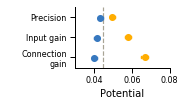

In [5]:
dodge = True
capsize = 0.1
aspect = 1.7  #1.9
errwidth = 1.3  # 3

g = sns.catplot(y="Mechanisms", x="Potential", hue="Attention", data=evo_avgs[evo_avgs['Attention'] != 'neutral'],
                height=4 * cm, aspect=aspect, kind="point",
                palette={'valid': colors[0], 'invalid': colors[1], 'neutral': colors[2]},
                legend=False, zorder=6, order=conds, join=False, dodge=dodge,
                capsize=capsize, errwidth=errwidth, orient='h')

g.set_yticklabels(['Precision', 'Input gain', 'Connection\ngain'])


means = evo_avgs.groupby(['Attention']).mean()
means = means.reset_index()
mean = means.loc[means['Attention'] == 'neutral', 'Potential'].values

limits = np.array([0.03, 0.08])
plt.xlim(limits)

g.ax.set_xticks([0.04, 0.06, 0.08])
g.ax.set_xlabel('Potential')
g.ax.set_ylabel(' ')
g.ax.axvline(mean, c=colors[2], ls='--', zorder=0)

plt.tight_layout()

sns.despine(top=True, right=True)
if save == True:
    g.savefig(output_path + 'EvokedPotentials.pdf', dpi=300, transparent=True)
else:
    plt.show()


In [7]:
import random

comps = ['valid vs invalid', 'valid vs neutral', 'invalid vs neutral']
results = {}
results_df = pd.DataFrame([], columns=['Mechanism', 'Comparison', 'Difference', 'p-values', 'significant'])

# Define p (number of permutations):
p = 10000

results['Permutations'] = p
results['alpha-level'] = 0.05 / len(comps)
for cond in conds:
    if cond not in results:
        results[cond] = {}
    print(cond)
    validPreds = evo_avgs.loc[(evo_avgs['Mechanisms']==cond) & (evo_avgs['Attention']=='valid'), 'Potential'].values
    invalidPreds = evo_avgs.loc[(evo_avgs['Mechanisms']==cond) & (evo_avgs['Attention']=='invalid'), 'Potential'].values
    neutralPreds = evo_avgs.loc[(evo_avgs['Mechanisms']==cond) & (evo_avgs['Attention']=='neutral'), 'Potential'].values
    idx = np.arange(len(validPreds) * 2)
    for comp in comps:
        if comp not in results[cond]:
            print(comp)
            if comp == 'valid vs invalid':
                diff = np.abs(np.mean(validPreds) - np.mean(invalidPreds))
                samplePreds = np.concatenate([validPreds, invalidPreds], axis=0)
            elif comp == 'valid vs neutral':
                diff = np.abs(np.mean(validPreds) - np.mean(neutralPreds))

                samplePreds = np.concatenate([validPreds, neutralPreds], axis=0)
            elif comp == 'invalid vs neutral':
                diff = np.abs(np.mean(invalidPreds) - np.mean(neutralPreds))

                samplePreds = np.concatenate([invalidPreds, neutralPreds], axis=0)
            else:
                raise ValueError('Comparison is not specified.')

            # Initialize permutation:
            pD = []

            # Permutation loop:
            for i in range(0, p):
                random.shuffle(idx)
                pD.append(np.abs(np.mean(samplePreds[idx[:int(len(idx)//2)]]) - np.mean(samplePreds[idx[int(len(idx) // 2):]])))

            p_val = len(np.where(pD>=diff)[0])/p
            print(cond + ': ' + str(p_val))

            results[cond][comp] = {}
            results[cond][comp]['Observed difference'] = diff
            results[cond][comp]['Difference distribution'] = pD
            results[cond][comp]['p-value']= p_val

            results_df = results_df.append({'Mechanism':cond, 'Comparison':comp, 'Difference':diff, 'p-values':p_val, 'significant':p_val<results['alpha-level']},ignore_index=True )


joblib.dump(results,
            dir_path + '/ModelAnalysis/EvokedPermutationTestsComparisons.pkl',
            compress=True)
results_df.to_csv(dir_path + '/ModelAnalysis/EvokedPermutationTestsComparisons_df.csv')



precision
valid vs invalid


precision: 0.0
valid vs neutral


precision: 0.0006
invalid vs neutral


precision: 0.0
inputGain
valid vs invalid


KeyboardInterrupt: 